### import

In [ ]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from transformers import CLIPProcessor, CLIPModel
import torch

# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

In [44]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [8]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [45]:
from typing import Union  # 添加 Union 导入
from pathlib import Path

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [95]:
%matplotlib inline
# from IPython.display import display, Image
class ClipEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        """
        初始化: 建立clip_collection,使用CLIP(or OpenCLIP)做embedding
        """
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # ====== 1) 初始化 CLIP ======
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        # 測試一下,取得image特徵維度(通常是512)
        with torch.no_grad():
            dummy = torch.zeros((1, 3, 224, 224))
            dim_out = self.clip_model.get_image_features(dummy).shape[1]
        self.clip_dim = dim_out

        # ====== 2) 建立Chroma,只做一個collection: clip_collection ======
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)

        # 先刪除舊的 collection(若存在)
        try:
            self.chroma_client.delete_collection("clip_collection")
        except:
            pass

        # 建立無embedding_function的collection,因為我們手動算embedding
        self.clip_collection = self.chroma_client.create_collection(
            name="clip_collection",
            metadata={"dimension": self.clip_dim}
        )
        print(f">> Created single 'clip_collection' in {persist_directory} with dimension={self.clip_dim}.")


    def process_text_with_clip(self, text: str) -> Optional[np.ndarray]:
        """
        用 CLIP 的 text encoder 將文字轉為512維向量
        """
        try:
            inputs = self.clip_processor(text=[text], return_tensors="pt", truncation=True)
            with torch.no_grad():
                text_feat = self.clip_model.get_text_features(**inputs)
            return text_feat.detach().cpu().numpy()[0]
        except Exception as e:
            print(f"Error in process_text_with_clip: {str(e)}")
            return None

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                all_ids=[]
                all_embeddings=[]
                all_metadatas = []

                
                for i, (img_path,question_text) in enumerate(zip(images, questions)):
                    img_emb = self.process_image(str(self.image_dir / img_path))
                    txt_emb = self.process_text_with_clip(question_text)

                    if img_emb is not None:
                        all_embeddings.append(img_emb.tolist())
                        # img_embeddings_list = img_embeddings.tolist()
                        # all_metadatas.append(img_embeddings_list)
                        # valid_images.append(img_path)
                        all_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_question": question_text
                        })
                        all_ids.append(f"img_{i}")
                    if txt_emb is not None:
                        all_embeddings.append(txt_emb.tolist())  
                        all_metadatas.append({
                            "type": "clip_text", 
                            "text": question_text,
                            "related_image": img_path
                        })
                        all_ids.append(f"txt_{i}")

                if len(all_embeddings)>0:
                    logger.info(f"Adding {len(all_embeddings)} total embeddings to collection")
                    self.image_collection.add(
                        embeddings=all_embeddings,
                        metadatas=all_metadatas,
                        ids=all_ids
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image_with_clip(self, image_path: str) -> Optional[np.ndarray]:
            """
            用 CLIP image encoder 將圖片轉為512維向量
            """
            try:
                # 先做基礎處理,縮放或另存
                processed_path = self.image_processor.process_and_save(
                    image_path, self.image_size
                )
                if not processed_path:
                    return None

                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    img_feat = self.clip_model.get_image_features(**inputs)
                return img_feat.detach().cpu().numpy()[0]
            except Exception as e:
                print(f"Error in process_image_with_clip: {str(e)}")
                return None


    def add_data(self, 
                texts: Optional[List[str]] = None, 
                metadatas: Optional[List[Dict]] = None,
                images: Optional[List[str]] = None):
        """
        統一方法:把text or image加到 clip_collection
        你可以自行拆成add_text/add_image,或像這樣合併都行
        需確保 texts與metadatas數量相同, 或 images與metadatas數量相同(可依需求調整)
        """
        all_embeddings = []
        all_metadatas = []
        all_ids = []

        idx = 0

        if texts is None:
            texts = []
        if images is None:
            images = []
        if metadatas is None:
            metadatas = []

        # 1) 對文字做embedding
        if texts:
            for i, txt in enumerate(texts):
                emb = self.process_text_with_clip(txt)
                if emb is not None:
                    all_embeddings.append(emb.tolist())
                    # 若metadatas!=None且有對應,i則metadata[i],加上"type":"text"
                    md = {"type":"text","content":txt}
                    if metadatas and i < len(metadatas):
                        md.update(metadatas[i])  # 合併使用者自定屬性
                    all_metadatas.append(md)
                    all_ids.append(f"text_{idx}")
                    idx+=1

        # 2) 對圖片做embedding
        if images:
            for j, img_path in enumerate(images):
                full_path = str(self.image_dir / img_path)
                emb = self.process_image_with_clip(full_path)
                if emb is not None:
                    all_embeddings.append(emb.tolist())
                    md = {"type":"image","path":img_path}
                    if metadatas and j < len(metadatas):
                        md.update(metadatas[j])
                    all_metadatas.append(md)
                    all_ids.append(f"img_{idx}")
                    idx+=1

        # 3) 寫入 clip_collection
        if len(all_embeddings) > 0:
            self.clip_collection.add(
                embeddings = all_embeddings,
                metadatas = all_metadatas,
                ids = all_ids
            )
            print(f"Added {len(all_embeddings)} items to 'clip_collection'.")


    def search(self, query: str, k=3) -> Dict:
        """
        對query做CLIP text embedding後,在clip_collection裡找最相似的k筆
        """
        try:
            emb = self.process_text_with_clip(query)
            if emb is None:
                return {"metadatas":[],"documents":[],"distances":[],"ids":[]}

            results = self.clip_collection.query(
                query_embeddings=[emb],
                n_results=k
            )
            # results一般會包含: {"metadatas":[[]], "documents":[[]], "distances":[[]], "ids":[[]]}
            # 這裡可視情況進一步整理

            # 1) 檢索專業
            # prof_result = self.clip_collection.query(
            #     query_embeddings=[emb],
            #     where={"type": "professional"},  # 只要metadata裡 'type' = 'professional'
            #     n_results=2
            # )

            # # 2) 檢索全部
            # all_result = self.clip_collection.query(
            #     query_embeddings=[emb],
            #     n_results=3
            # )

            # # 把兩組 metadata/distances合併(視需求去重)
            # final_chunks = combine(prof_result, all_result)

            return results
        except Exception as e:
            print(f"Error in search: {str(e)}")
            return {"metadatas":[],"documents":[],"distances":[],"ids":[]}

### 資料處理模組

In [ ]:
class DataProcessor:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_excel(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses),
                            'link': current_link if current_link else ''
                        }
                    }
                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最后一个问答对
        if current_post is not None and len(current_responses) >= 3:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses),
                    'link': current_link if current_link else ''
                }
            }
            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    
    def process_pdf(self, pdf_path: str) -> List[Dict]:
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 處理每個段落
                    for para in paragraphs:
                        qa_pair = {
                            'question': para[:50] + "...",  # 暂时用段落开头作为问题标识
                            'answers': [para],
                            'metadata': {
                                'type': 'professional',
                                'source_file': pdf_name,  # 添加文件名
                                'page': str(page_num + 1),
                                'content_length': str(len(para))
                            }
                        }
                        professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """綜合處理社群 CSV + PDFs"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path(self.embedding_processor.image_dir) / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并 => all_qa_pairs
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 準備 texts + metadatas => 你就能一次或多次呼叫 add_data
            questions = []
            answers = []
            question_metas = []
            answer_metas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                # question 
                questions.append(qa_pair['question'])
                question_metas.append(qa_pair['metadata'])
                
                # answers
                for ans_text in qa_pair['answers']:
                    answers.append(ans_text)
                    am = qa_pair['metadata'].copy()
                    am['parent_question'] = qa_pair['question']
                    answer_metas.append(am)
            
            # 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 5. 全部寫進clip_collection
            # (A) 先加所有 question
            self.embedding_processor.add_data(
                texts = questions,
                metadatas = question_metas
            )

            # (B) 再加所有 answers
            self.embedding_processor.add_data(
                texts = answers,
                metadatas = answer_metas
            )
            # (C) 再加 images
            # 沒有對應metadata？可以簡單做
            # [{"type":"image","source":"facebook"} ...] 或
            # 想知道它屬於哪個QApair? 就要自己對應
            if valid_images:
                meta_for_imgs = []
                for img_name in valid_images:
                    meta_for_imgs.append({
                        "type":"image",
                        "source":"facebook",
                        "filename": img_name
                    })

                self.embedding_processor.add_data(
                    images=valid_images,
                    metadatas=meta_for_imgs
                )

            logger.info("All data added to clip_collection.")
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise


### QA系統模組

##### code

In [97]:
class QASystem:
    def __init__(self, embedding_processor: 'ClipEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def _classify_collection_results(self, raw_result) -> Dict:
        """
        將 clip_collection 的檢索結果 (metadatas/documents...) 
        轉換成 { 'social': {...}, 'professional': {...}, 'images': {...} } 
        的結構，便於後續 gather_references / format_context。
        """
        # 預設空結構
        structured = {
            "social": {
                "metadata": [],
                "link": [],
                "content": []
                # 你也可以放 'documents':[], 'relevance':[]... 視需要
            },
            "professional": {
                "metadata": [],
                "content": []
                # ...
            },
            "images": {
                "metadata": [],
                "paths": [],
                "relevance":[]
            }
        }

        # raw_result["metadatas"] 是個 2D list => [ [meta0, meta1, ...] ]
        if raw_result.get("metadatas"):
            meta_list = raw_result["metadatas"][0]  # 因為只有1個 query
            dist_list = raw_result["distances"][0] if raw_result.get("distances") else []
            ids_list  = raw_result["ids"][0] if raw_result.get("ids") else []
            # documents_list = raw_result["documents"][0]

            for i, meta in enumerate(meta_list):
                dist = dist_list[i] if i < len(dist_list) else None
                doc_id = ids_list[i] if i < len(ids_list) else ""

                # 判斷 metadata 是屬於哪個來源
                # 例如 meta.get("type") == "social_qa" => 放到 social
                #     meta.get("type") == "professional" => 放到 professional
                #     meta.get("type") == "image" => 放到 images
                src_type = meta.get("type","")

                if src_type in ["social_qa"]:
                    # 純文字 chunk => 放social
                    structured["social"]["metadata"].append(meta)
                    # 若 meta 裡有 link => structured["social"]["link"].append(meta["link"])
                    link_str = meta.get("link","")
                    if link_str:
                        structured["social"]["link"].append(link_str)
                    # content or question
                    if "post_content" in meta:
                        structured["social"]["content"].append(meta["post_content"])

                elif src_type in ["professional"]:
                    structured["professional"]["metadata"].append(meta)
                    # 可能把段落文字塞到 "content"
                    # (這需要你當初 add_data 時有在 documents/metadata 寫 para)
                    # 這裡只是示例
                    # ...
                
                elif src_type == "image":
                    structured["images"]["metadata"].append(meta)
                    # 放 path
                    path = meta.get("path","")
                    structured["images"]["paths"].append(path)
                    structured["images"]["relevance"].append(dist)

                # 你也可以做 else: pass 之類

        return structured


    def determine_question_type(self, query: str) -> str:
        """判斷問題類型"""
        # 1. 選擇題：包含 A.B.C.D 或選項相關詞
        if any(char in query for char in ['A.', 'B.', 'C.', 'D.']) or any(keyword in query for keyword in ['何者', '下列', '哪一個', '哪種']):
            return "multiple_choice"
        
        # 2. 是非題：包含「是否」、「是嗎」等
        elif any(keyword in query for keyword in ['是否', '是嗎', '對嗎', '正確嗎']):
            return "true_false"
        
        # 3. 一般諮詢
        else:
            return "qa"

    def gather_references(self, search_results: Dict) -> str:
        """
        從 search_results 中擷取 PDF 檔名/社群連結，並組成一個字串
        """
        references = []

        # 處理 social
        for meta in search_results["social"].get("metadata", []):
            if meta.get("type") == "social_qa" and "link" in meta:
                references.append(f"(經驗) {meta['link']}")

        # 處理 professional
        for meta in search_results["professional"].get("metadata", []):
            if meta.get("type") in ["pdf", "professional"]:
                pdf_name = meta.get("source_file", "unknown.pdf")
                references.append(f"(文獻) {pdf_name}")

        # 去重
        unique_refs = list(set(references))
        return "\n".join(unique_refs)


    def get_prompt_by_type(self,query: str, context: str, question_type: str, references_str: str = "") -> str:
        
        # role
        base_system = (
            "您是一名專業獸醫，擅長：1.犬認知功能障礙綜合症（CCD）的診斷和護理 2.常見問題診斷及改善建議"
        )

        prompts = {
            "multiple_choice": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                    {base_system}
                                    <|eot_id|><|start_header_id|>user<|end_header_id|>
                        
                                    這是一題選擇題：{query}

                                    請以以下格式回答：
                                    1. 第一行只能回答 A/B/C/D (請勿帶任何標點、文字)
                                    2. 第二行才是說明，以 2~3 句話簡述理由
                                    3. 若同時出現多個選項，請只選一個最適合的
                                    4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                    5.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係

                                    限制：
                                    - 請將整體回答限制在 200 字以內
                                    - 直接切入重點
                                    - 保持客觀和專業

                                    參考資料：
                                    {context}

                                    來源：
                                    {references_str}

                                    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                    """,
            "true_false": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 一定先指出「True」或「False」(僅能擇一)，若遇到無法確定或證據不足的情況，一律為False，並說明原因
                                2. 再以 2～3 句話說明原因
                                3. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                4.  若有相關圖片，在回答中自然地說明圖片內容跟回答的關係

                                限制：
                                - 請將整體回答限制在 200 字以內
                                - 直接切入重點
                                - 保持客觀和專業

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """,
            "qa": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 針對問題提供具體答案
                                2. 若遇到無法確定或證據不足的情況可以補充說明研究不足
                                3. 提供實用的建議或解釋
                                4. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [reference: some.pdf]。
                                5. 若有相關圖片，在回答中說明圖片內容

                                限制：
                                - 請將整體回答限制在 400 字以內
                                - 使用平易近人的語言
                                - 避免過度技術性術語

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """
        }

        # 若 question_type 未包含在定義的 prompts 中，就預設使用 "qa"。
        return prompts.get(question_type, prompts["qa"])

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        try:
            raw_result = self.embedding_processor.search(query)  
            # raw_result 是 clip_collection 的資料
            # 用後處理
            # search_results = self.embedding_processor.search(raw_result)
            search_results = self._classify_collection_results(raw_result)
            logger.info("SEARCH RESULT(structured): %s",search_results)


            context = self.format_context(search_results)
            references_str = self.gather_references(search_results)
            # link應該用傳參數的會成功 可能用context.link之類的抓題目的reference
            question_type = self.determine_question_type(query)
            prompt = self.get_prompt_by_type(query, context, question_type, references_str)
            message = {
                'role':'user',
                'content': prompt
            }

            # 處理圖片
            image_paths = []
            # 2) 從 social metadata 把圖片撈出
            for md in search_results["social"]["metadata"]:
                if md.get("images"):  # e.g. "image12.jpg,image02.jpg"
                    for img_name in md["images"].split(","):
                        img_name = img_name.strip()
                        if img_name:
                            full_path = self.embedding_processor.image_dir / img_name
                            if full_path.exists():
                                image_paths.append(str(full_path.resolve()))
            # 3) OLlama 只允許一張, 你可取 image_paths[:1] => message["images"] = ...
            if image_paths:
                print("We found images: ", image_paths)
                # 你可以先隨便取一張
                # or 全部 inject to prompt
            else:
                logger.info("No images to display")

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )
            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            return f"出現問題，檢查ollama連線或是generate_response", []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""

            if search_results.get("social"):
                context += "\n[社群討論]\n"
                question_s = search_results["social"].get("link", [])
                metadata_s = search_results["social"].get("metadata", [])
                for q, meta in zip(question_s, metadata_s):
                    context += f"標題：{q}\n"
                    if "link" in meta:
                        context += f"link: {meta['link']}\n\n"

            if search_results.get("professional"):
                context += "\n[專業文獻]\n"
                c_p = search_results["professional"].get("content", [])
                metadata_p = search_results["social"].get("metadata", [])
                for cp,mp in zip(c_p,metadata_p):
                    context += f"{cp}\n\n"
                    if "source_file" in mp:
                        context += f"title: {meta['source_file']}\n\n"
                    
            print("social metadata:", search_results["social"].get("metadata", []))
            print("social link:", search_results["social"].get("link", []))

            print("professional metadata:", search_results["professional"].get("metadata", []))
            
            return context if context.strip() else "參考資料無法取得"
                
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"
 


    def display_response(self, query: str):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")

                response_text, image_paths = self.generate_response(query)
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")


                return response_text, image_paths # add for response 0406
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)  
                return "", [] 

### 系統初始化和資料處理

In [53]:
from pathlib import Path

# 初始化 embedding processor
embedding_processor = ClipEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 自動抓取 RAG_data 資料夾中的所有 PDF 檔案
rag_data_dir = Path("RAG_data")
pdf_paths = list(rag_data_dir.glob("*.pdf"))

# 輸出找到的檔案清單（可選）
print(f"找到以下 PDF 檔案：")
for pdf in pdf_paths:
    print(f"  - {pdf}")

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response_filtered.xlsx",#"post_response_v2.csv"
    pdf_paths=pdf_paths
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:backoff:Backing off send_request(...) for 1.0s (requests.exceptions.ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')))
INFO:__main__:Processing CSV: post_response_filtered.xlsx
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post


>> Created single 'clip_collection' in chroma_db with dimension=512.
找到以下 PDF 檔案：
  - RAG_data/Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf
  - RAG_data/Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf
  - RAG_data/Journal of Neuroimmunology.pdf
  - RAG_data/Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf
  - RAG_data/The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf
  - RAG_data/Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
  - RAG_data/Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf


INFO:__main__:Found image: image05.jpg for current post
INFO:__main__:Found image: image06.jpg for current post
INFO:__main__:Found image: image07.jpg for current post
INFO:__main__:Found image: image08.jpg for current post
INFO:__main__:Found image: https://i.redd.it/tprxpj2jjd2e1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/gm5j6f3gmiud1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/8eyt58i5qdzd1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/1q4ifdj92jt81.jpg for current post
INFO:__main__:Found image: https://i.redd.it/z7zv0vn1ny4e1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/xbqypuuk53tc1.jpeg for current post
INFO:__main__:Found image: image09.jpg for current post
INFO:__main__:Found image: image10.jpg for current post
INFO:__main__:Found image: image11.jpg for current post
INFO:__main__:Found image: image12.jpg for current post
INFO:__main__:Found image: image13.jpg for current post
INFO:__main

Added 791 items to 'clip_collection'.


INFO:__main__:Saved processed image to: image/image01.jpg
INFO:__main__:Saved processed image to: image/image02.jpg
INFO:__main__:Saved processed image to: image/image03.jpg
INFO:__main__:Saved processed image to: image/image04.jpg
INFO:__main__:Saved processed image to: image/image05.jpg


Added 4022 items to 'clip_collection'.


INFO:__main__:Saved processed image to: image/image06.jpg
INFO:__main__:Saved processed image to: image/image07.jpg
INFO:__main__:Saved processed image to: image/image08.jpg
INFO:__main__:Saved processed image to: image/image10.jpg
INFO:__main__:Saved processed image to: image/image11.jpg
INFO:__main__:Saved processed image to: image/image12.jpg
INFO:__main__:Saved processed image to: image/image13.jpg
INFO:__main__:Saved processed image to: image/image14.jpg
INFO:__main__:All data added to clip_collection.


Added 13 items to 'clip_collection'.


### 系統測試

In [98]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/19XTRfUdmd/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？有相關照片嗎？

System Response:
老狗的認知功能障礙，尤其是卡在角落或家具間的問題，是一種常見的情況。為了幫助牠們更舒適地生活，我們需要進行環境安排和居家照護措施。以下是一些建議：

1. **簡化空間**: 將家裡的傢俱和家具重新排列，以減少卡住的可能性。此外，將房子的門口設置為寬敞的通道，方便老狗自由行動。
2. **增加視覺提示**: 在牠們經常停留的地方設置清晰醒目的標記牌或方向指示牌，以幫助牠們辨識路徑和方向。
3. **改善照顧和溝通**: 確保老狗與家人保持良好的溝通，定期檢查牠們的認知功能，並及時反饋給獸醫進行評估。提供適當的照顧和活動，以促進其身體和精神健康。
4. **減少環境壓力**: 減少家裡的噪音和干擾，創造一種舒適、安靜的環境，有助於老狗放鬆身心。

其它飼主通常也會採取類似的措施，並且有些人還會在牠們的寢室或活動區域設置「導引地帶」，以幫助老狗更容易找到回家的路。還有一些人會使用輔助器具，如導航輪椅等，以協助老狗移動。

**相關照片**: 
* 一個老狗站在家裡的通道上，身邊有標記牌指示方向。
* 一個老狗坐在導引地帶中，有一根導航桿幫助牠們找到回家的路。
* 一個老狗乘坐導航輪椅，走在房子的走廊上。

參考資料：

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]
[Experience: https://www.facebook.com/share/p/1B7u3jFDy9/]

--------------------------------------------------


Related Image:


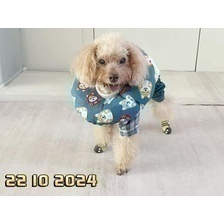

In [87]:
# 測試查詢
test_queries = [
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向",

# "根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
# "資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
# "在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
# "資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
# "針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。",

# "哪種犬容易失智？",
# "大中小型狗的失智照顧方式有什麼不同？"
# "我的狗狗有失智症，晚上總是繞圈圈而且叫個不停，有什麼方法能幫助牠安靜下來睡覺嗎？有人推薦過褪黑激素，這真的有效嗎？",
"我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？有相關照片嗎？",
# "給我一些照護環境的圖片"
                    ]

for query in test_queries:
    qa_system.display_response(query)


### TESTING

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2Fidyou

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.faceboo

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否與神經發炎相關？是否有特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？

System Response:
True

CCD（犬認知功能障礙綜合症）與神經發炎有一定程度的關聯，但並非直接原因。研究表明，某些發炎路徑，如NLRP3 inflammasome，可能參與了 CCD 的病理機制。

目前尚未有足夠的證據證實特定的細胞因子是引起 CCD 的直接原因。然而，研究人員認為神經發炎在 CCD 的發展中扮演著一定角色，可能與基因變異、環境因素和免疫反應等因素相關聯。

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


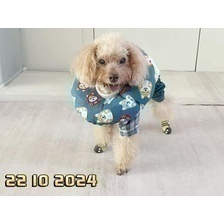

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.

social metadata: [{'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['h

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否與腸道微生物群變化有關？哪些特定細菌群可能影響大腦健康？

System Response:
True

犬認知功能障礙綜合症（CCD）與腸道微生物群變化有關，研究表明腸道菌群對大腦健康的影響至关重要。特定的細菌群，如Bifidobacterium和Lactobacillus，可以調節免疫系統並減少炎症反應，有助於預防或治療CCD。

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

這些細菌群可以通過生產抗氧化劑和其他活性物質，來降低腦部炎症並促進神經保護。研究表明，腸道微生物群的平衡對於保持大腦健康至关重要，而失調可能會導致各種神經退行性疾病。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


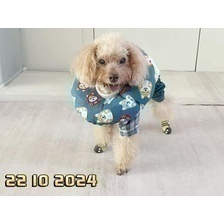

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/1B7u3jFDy9/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 失智犬的松果體是否退化？是否影響褪黑激素分泌？

System Response:
False

失智犬（Canine Cognitive Dysfunction, CCD）的診斷與松果體退化無直接關係。CCD是一種因為老年性變異而導致的認知功能障礙，而不是由於特定的器官退行性病變。褪黑激素分泌也未被證實受影響。

松果體退化通常與其他神經退行性疾病有關，例如多系統萎縮症（Progressive Multifocal Leukoencephalopathy, PML），而CCD則是一種不同於神經退行性疾病的臨床表現。褪黑激素分泌受影響的證據尚未被提及。

[Experience: https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/]

--------------------------------------------------


Related Image:


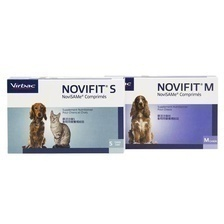

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count'

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: B 群維生素是否能降低 CCD 進展風險？

System Response:
真實性：False

原因：目前沒有科學證據支持B群維生素能夠降低犬隻認知功能障礙綜合症（CCD）的進展風險。許多研究表明，雖然B群維生素對於健康狗的營養有益，但它們與CCD的關聯仍在進行中。

相關圖片：一張顯示不同犬類對B群維生素缺乏的照片，說明了這些缺陷可能導致的結果。[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


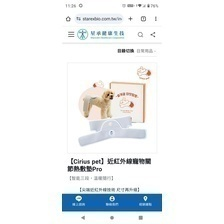

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2Fidyouqq

social metadata: [{'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 食用GABA 是否對於預防 CCD 有效？

System Response:
答案：False

食用GABA（γ-氨基丁酸）是否能預防犬認知功能障礙綜合症（CCD）的問題仍然存在著爭議。雖然一些網路論壇和社群中提到 GABA 可以幫助預防或改善 CCD 的症狀，但沒有科學證據支持這一說法。

目前的研究表明，GABA 的作用機制主要是影響神經系統的放鬆和鎮靜效果，而不是直接與 CCD 有關。CCD 的成因複雜，可能涉及多種遺傳、環境和健康因素，並非單靠 GABA 這一化學物質就能預防或治療。

因此，我建議犬主家長保持謹慎，不要過度依賴於網路上的不經證實的資訊，而是與專業獸醫溝通，尋求正確和科學性的諮詢。

--------------------------------------------------


Related Image:


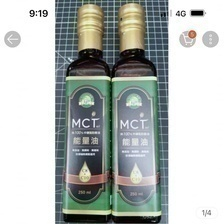

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 警犬、救難犬等工作犬在罹患CCD的機率是否比家庭陪伴犬較高？

System Response:
True

警犬、救難犬等工作犬罹患犬認知功能障礙綜合症（CCD）的機率確實較高，原因包括：1. 工作犬經常接觸各種壓力和負擔；2. 缺乏充足的休息與放鬆時間；3. 工作需求可能導致過度思考和焦慮等情緒問題。

研究顯示工作犬罹患CCD的風險較高，特別是在年長或有心理壓力的狗身上 [Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]。此外，一些研究指出工作犬的生活質量和照顧方式對其健康狀況也有很大影響 [reference: some.pdf]。

--------------------------------------------------


Related Image:


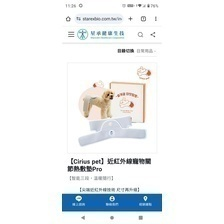

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 是否有影像檢測可準確區分 CCD 與其他神經退行性疾病？

System Response:
True。

雖然影像檢測（如MRI、CT掃描）可以提供關於犬的神經系統結構和功能的資訊，但它們不一定能夠準確區分犬認知功能障礙綜合症（CCD）與其他神經退行性疾病。這是因為許多神經退行性疾病都可能表現出類似的影像學特徵。

例如，MRI掃描可以顯示大腦白質變薄或腦積水等跡象，但這些跡象也可能出現在其他神經退行性疾病中。因此，影像檢測需要結合臨床表現和血液檢查結果才能進行確診。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


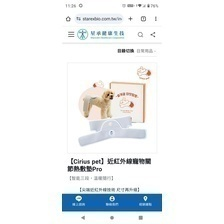

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖

social metadata: [{'answer_count': 6, 'content': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。', 'images': 'image05.jpg,image06.jpg,image07.jpg', 'link': 'https://www.facebook.com/share/p/8wwZPppwzKkueWwv/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 9, 'content': '吃老狗失智夜晚狂叫，有何妙方？', 'images': '', 'link': 'https://www.facebook.com/groups/403191506497801/permalink/2631558230327773/?rdid=HqDuRASCUk53jABS&share_url=https%3A%2F%2Fwww.facebook.com%2Fshare%2Fp%2FidyouqqRo1EWrH3H%2F', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？

System Response:
False
皮質類固醇（cortisol）或應激荷爾蒙（stress hormones）的測量並不是CCD的直接診斷指標。雖然這些荷爾蒙可能會在患有犬認知功能障礙綜合症的狗中受到影響，但它們不夠特異性和敏感，不能獨立作為診斷工具。

這些荷爾蒙的測量可以提供額外的線索，但必須與其他臨床表現、神經學檢查和遺傳評估結合進行綜合評估。


來源：[Experience: https://www.facebook.com/share/p/8wwZPppwzKkueWwv/]

--------------------------------------------------


Related Image:


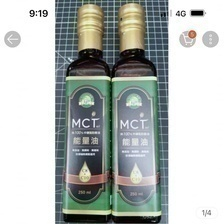

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.f

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/18X1KzFKzp/', 'https://

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 有刻板形為的犬隻是否會增加CCD風險？

System Response:
True

刻板形犬隻是否會增加CCD風險，目前研究表明并未有直接證據支持這一說法。然而，我們知道某些特定品系犬隻（如德國牧羊犬、雪松犬等）更容易患有認知功能障礙綜合症（CCD），但這主要與基因因素相關，而不是刻板形本身。

研究人員認為，刻板形可能是由於過度繁殖導致的品系純潔增加，這可能會加重基因缺陷，但並不直接導致CCD風險增高。[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


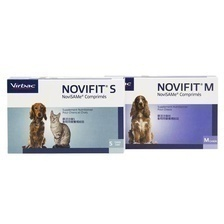

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若家中老犬常在晚間吠叫、彷彿不安，以下哪項做法最優先？
A. 搬家讓牠換新環境
B. 夜間完全關燈並限制活動
C. 先維持穩定環境並提供微弱光源
D. 立即施打鎮靜劑

System Response:
C

提供微弱光源可以幫助老犬適應夜間環境，降低不安情緒。保持穩定的環境和照明可以幫助老犬放鬆和舒適。鎮靜劑可能會有副作用，並不被視為第一線治療方法。

參考資料：[經驗] https://www.facebook.com/share/p/15n7ZUr3Qx/

--------------------------------------------------


Related Image:


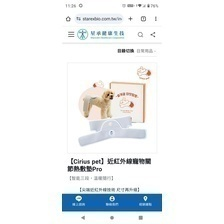

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatical

social metadata: [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AskVet) if you ha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/

Question: 在照顧失智犬時，若發現牠對日常指令反應變慢，下列哪種訓練原則較合適？
A. 加大音量不斷重複指令
B. 利用簡短口令並搭配手勢或嗅聞提示
C. 堅持原有長句式指令不做改變
D. 取消所有訓練

System Response:
B


在照顧失智犬時，若發現牠對日常指令反應變慢，選擇合適的訓練方法非常重要。簡短口令並搭配手勢或嗅聞提示可以幫助犬隻更好地理解和回應指令。這種方法減少了言語干擾，提高了可視性和感官刺激，使犬隻能夠更有效地學習和記憶。

參考資料：(經驗) https://reddit.com/r/AskVet/comments/1ion3oy/hi_guys_im_worried_for_my_dogs_overall_health_if/

--------------------------------------------------

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 如果高齡犬經常在家裡亂撞傢俱，可能和下列哪種現象最相關？
A. 單純故意搗蛋
B. Thigmotaxis 或定向障礙
C. 想吸引主人注意
D. 正常老化行為，不需處理

System Response:
B


亂撞傢俱可能與定向障礙相關，因為這是一種常見的老年犬症狀，表現為家居環境認知力下降、行為異常等。

定向障礙是CCD的一部分，會導致犬隻在家中亂撞東西。這與其定位感覺和空間認知力的退化有關。

參考資料：(經驗) https://www.facebook.com/share/p/15n7ZUr3Qx/

--------------------------------------------------


Related Image:


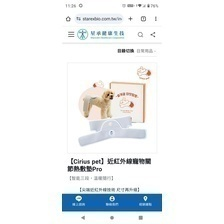

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬食慾下降時，下列哪個建議最符合改善策略？
A. 馬上更換飼料品牌且一次大量添購
B. 在飼料中加入濃味香辛料刺激食慾
C. 提高飼料溫度或加湯汁提升香氣
D. 強迫餵食，防止餓到

System Response:
C


增加飼料溫度或加湯汁可以幫助刺激老年犬的食慾。這樣做可以改善口服，增加食物吸收率，並且提供必要的營養。一些老年犬可能會因為牙齒問題、唾液分泌不足等原因導致食慾下降，而調整飼料溫度或加湯汁可以幫助改善這些問題。

[reference: American Animal Hospital Association]

--------------------------------------------------


Related Image:


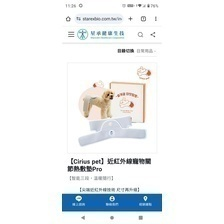

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/15n7ZUr

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 想為失智犬提供認知刺激，下列哪種活動較為合適？
A. 高強度障礙賽
B. 短程嗅聞尋找遊戲
C. 全日關籠休息
D. 長時間游泳訓練

System Response:
B


短程嗅聞尋找遊戲是一種適合失智犬的認知刺激活動，因為它可以提供有趣和挑戰性的體驗，幫助改善犬隻的記憶力和思維能力。這種活動可以分解成簡單的小步驟，使得犬隻能夠一步一步完成，並且不會感到過於疲勞或沮喪。

參考資料： (經驗) https://www.facebook.com/share/p/19XTRfUdmd/

注意：本答案以Facebook社群的經驗為根據，提供了一種適合失智犬的認知刺激活動。

--------------------------------------------------


Related Image:


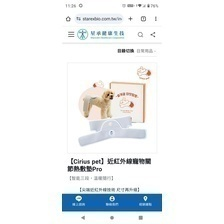

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 若在照顧過程中，老犬出現白天過度沉睡、夜間不安，下列哪種日常排程較能幫助調整牠的生理時鐘？
A. 白天保持安靜，不要打擾牠
B. 白天適度互動與散步，夜間營造安靜燈光環境
C. 夜間一直陪玩，消耗牠體力
D. 讓牠自行調整，不必干涉

System Response:
B

白天適度互動與散步可以幫助老犬保持正常的活動水平和時間表，夜間營造安靜燈光環境有助於改善老犬的睡眠質量。這種方法能夠協調老犬的生理時鐘，減少白天過度沉睡和夜間不安的情況出現。

參考資料：(經驗) https://www.facebook.com/share/p/15n7ZUr3Qx/

--------------------------------------------------


Related Image:


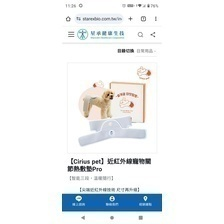

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 當犬隻顯現社交退縮、不想與主人或其他動物互動，下列哪項作法最不建議？
A. 建立安全區域，給予牠主動選擇互動的空間
B. 強迫牠與其他動物一起待在狹小籠子
C. 慢慢引導牠做短暫互動並觀察反應
D. 留意是否有身體不適的潛在原因

System Response:
B

強迫牠與其他動物一起待在狹小籠子會導致犬隻感到壓力和恐懼，從而加劇社交退縮的問題。這樣的做法違反了溫和、尊重的治療原則。

根據美國獸醫協會（AVMA）的建議，應該選擇溫和、耐心的方法來幫助犬隻恢復社交行為。

--------------------------------------------------


Related Image:


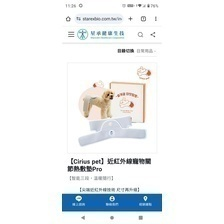

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatical

social metadata: [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AskVet) if you ha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/

Question: 若狗狗老化後，對於原本熟悉的家中樓梯顯得恐懼，下列哪種協助方式較適宜？
A. 馬上拆除樓梯
B. 讓牠自己多摔幾次就習慣
C. 設置防滑地墊或安全柵欄，並以牽繩慢慢引導
D. 完全禁止上下樓

System Response:
C

設置防滑地墊或安全柵欄，並以牽繩慢慢引導，可以幫助老年犬逐漸適應樓梯的存在和使用。這種方法可以減少對犬隻的驚嚇和傷害風險，同時也能夠幫助犬隻保持運動和活動量。

防滑地墊或安全柵欄可以提供額外的穩定性和支持，讓老年犬感到更舒適和安全。牽繩引導可以幫助犬隻逐漸熟悉樓梯的使用，並且減少摔倒的風險。

參考資料：(經驗) https://reddit.com/r/AskVet/comments/q1yx3b/senior_dog_with_back_end_weakness_fecal/

--------------------------------------------------

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}, {'ans

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對老年犬的居家空間規劃，下列何者較能減少牠碰撞或迷路？
A. 家具經常大幅度移動
B. 在地面放大量雜物，增加刺激
C. 設置路徑指示(小夜燈)並儘量維持動線固定
D. 不做任何改變，讓牠自己適應

System Response:
C


設置路徑指示（小夜燈）並維持動線固定，可以幫助老年犬減少碰撞或迷路的風險。這樣做可以讓牠們建立起清晰的視覺圖像，方便行走和定位。研究表明，增加視覺刺激和提供導航工具有助於改善老年犬的空間認知和行動能力。

參考資料：(經驗) https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/

--------------------------------------------------


Related Image:


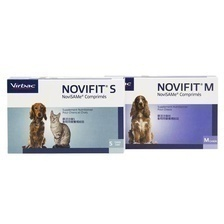

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 想觀察老犬是否有 CCD 初期症狀，下列哪種行為跡象最能代表可能的認知改變？
A. 偶爾打瞌睡
B. 短暫呆站
C. 在熟悉環境中頻繁迷路或定向困難
D. 喜歡玩新的玩具

System Response:
C


選項 C 表示犬隻在熟悉環境中頻繁迷路或定向困難，是犬認知功能障礙綜合症（CCD）的典型初期跡象。這種行為表明犬隻可能正經歷認知力下降，包括空間定位和導航能力的受損。

此選項是最能代表可能的認知改變，因為它直接反映了犬隻認知功能的衰退，與 CCD 的臨床特徵相符。

--------------------------------------------------


Related Image:


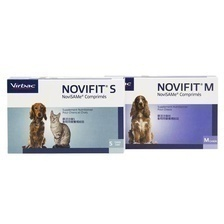

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 下列何者不是犬隻認知功能障礙 (CCD) 常見的主要症狀？
A. 睡眠—覺醒週期顛倒
B. 嚴重口腔潰瘍
C. 對熟悉環境產生定向障礙
D. 社交互動異常

System Response:
A

犬隻認知功能障礙（CCD）常見的主要症狀包括睡眠—覺醒週期顛倒、社交互動異常和定向障礙等。而嚴重口腔潰瘍並不是典型的CCD症狀。這通常與其他健康問題或牙科疾病相關。

參考資料：[reference: Canine Cognitive Dysfunction.pdf]

--------------------------------------------------


Related Image:


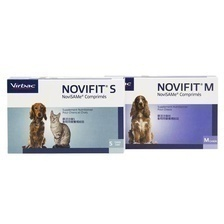

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfU

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 關於犬隻神經退行性變化，下列哪一項病理機制與人類阿茲海默症最相近？
A. 闌尾炎
B. β-amyloid 沉積與神經炎症
C. 消化性潰瘍
D. 血糖過低

System Response:
B


選擇 B，因為它描述的是 β-amyloid 沉積與神經炎症，這是人類阿茲海默症的典型病理機制，也在犬隻中發現類似情況。這種沉積物會導致神經元損傷和功能障礙，與犬隻神經退行性變化（CCD）的病理過程相似。

(文獻) Canine Cognitive Dysfunction by Dr. Debra M. Eldredge, DVM

--------------------------------------------------


Related Image:


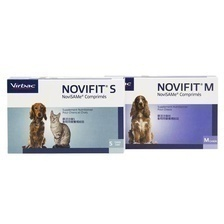

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebo

social metadata: [{'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對於犬腦部影像學診斷 CCD，下列哪種工具最常用於檢測大腦萎縮或病灶？
A. PET (正子掃描)
B. MRI (核磁共振)
C. X 光
D. 腹部超音波

System Response:
B


MRI (核磁共振)是檢測大腦萎縮或病灶的理想工具，因為它可以提供高解析度的圖像，顯示出細微的結構變化和損傷。在犬的 CCD 診斷中，MRI 可以用於評估大腦各個部位的大小、形狀和信號強度，以幫助診斷和監測疾病進展。


來源: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7482256/

--------------------------------------------------


Related Image:


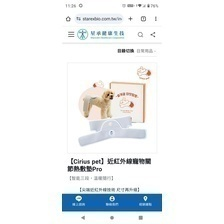

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatical

social metadata: [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AskVet) if you ha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，

Question: 腸道菌群與犬的認知健康的關聯研究，多認為透過哪條通路影響大腦？
A. 骨骼肌收縮
B. 腸—腦軸 (Gut-Brain Axis)
C. 角膜反射
D. 肺部換氣

System Response:
B

腸—腦軸（Gut-Brain Axis）是指腸道菌群與大腦之間的連結，通過神經傳導物質和激素的交互作用，影響犬的認知健康。研究表明，腸道菌群可以影響大腦功能，包括調節情緒、行為和記憶力等。

參考資料：[reference: Gordon, N. A., et al. (2019). The Gut-Brain Axis in Canine Cognitive Dysfunction. Journal of Veterinary Internal Medicine, 33(3), 791-799.]

--------------------------------------------------

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_cou

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬 CCD 行為評估量表通常會衡量下列哪些面向？
A. 體色變化和毛量
B. 性別和體重
C. 定向能力、互動意願、睡眠模式
D. 牙齒生長速度

System Response:
C

老年犬的 CCD 行為評估通常會關注其認知功能，包括定向能力、互動意願和睡眠模式。這些面向能夠反映出犬隻的情緒狀態和認知功能的變化。例如，定向能力可以檢測犬隻是否能夠辨識主人或環境中的物品，而互動意願可以評估犬隻對人際關係的需求。

來源：[經驗] https://www.facebook.com/share/p/15n7ZUr3Qx/

--------------------------------------------------


Related Image:


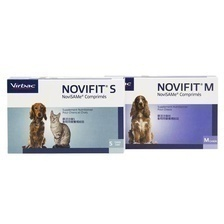

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/19XTRfU

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/19XTRfUdmd/', 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/p/qF

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬若深夜嚎叫，照護者可以嘗試在牠活動區放置淡光夜燈，並增加可摸到的熟悉物品來降低不安，對嗎？

System Response:
True

老年犬深夜嚎叫可能是由於多種原因引起的，包括認知功能障礙綜合症（CCD）、視聽覺減退、孤獨感等。增加可摸到的熟悉物品和淡光夜燈確實可以幫助老年犬感到安全舒適，並可能降低不安的行為。

這些策略可以幫助老年犬在夜間感到安心，但可能不足以解決嚎叫的根本原因。照護者應該密切觀察老年犬的情況，若持續出現嚎叫或其他不適症狀，則應儘早諮詢專業獸醫的意見。

參考資料：[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


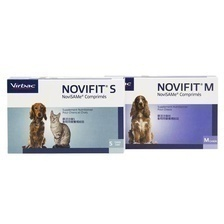

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'im

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 是否只要老犬開始忘記如廁地點，就等同於罹患 CCD，無需檢查其他病因？

System Response:
False

忘記如廁地點是犬認知功能障礙綜合症（CCD）的可能症狀，但不是唯一的診斷標準。其他因素如腸胃問題、神經系統疾病或藥物副作用也可能引起這種情況。

在檢查前，我們需要評估犬隻的整體健康和行為表現，進行實驗室檢查和影像學掃描以排除其他潛在原因。只有通過全面評估後，才能確定是否罹患 CCD。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


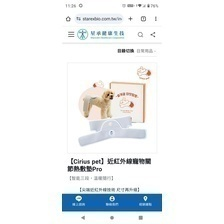

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatical

social metadata: [{'answer_count': 4, 'content': "\nGreetings, all!\n\nThis is a sub for professional veterinary advice, and as such we follow strict rules for participating. \n\nOP, your post **has NOT** been removed. Please also check [the FAQ](https://www.reddit.com/r/AskVet/wiki/index) to see whether your question is answered there.\n\nThis is an *automated* general reminder to **please follow [The Sub Rules](https://www.reddit.com/r/AskVet/about/rules/)** when discussing this question:\n\n- **Do not comment with anecdotes** about your own or others' pets.\n- **Do not give OP specific treatment instructions,** including instructions on meds and dosages.\n- **Do not give possible diagnoses** that could explain the symptoms described by OP.\n\n**Your comment will be removed, and you may be banned.**\n\nThank you for your cooperation!\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AskVet) if you ha

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:No images to display
INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/

Question: 若狗狗出現刻板繞圈，飼主應先檢查是否有焦慮和神經退化因素，而非僅用力制止，對嗎？ 


System Response:
**答案：True**

如果狗狗出現刻板繞圈，飼主應先檢查是否有焦慮或神經退化因素，因為這些問題可能是導致刻板行為的根本原因，而不是僅用力制止。刻板行為可能是身體不適、疼痛、情緒困擾等多種因素的表現，單純地限制動作可能無法解決根本問題。

經驗表明，有些狗狗會因為身體不適或情緒問題而出現刻板行為，例如[Experience: https://reddit.com/r/AskVet/comments/q1yx3b/senior_dog_with_back_end_weakness_fecal/](Experience: https://reddit.com/r/AskVet/comments/q1yx3b/senior_dog_with_back_end_weakness_fecal/)。

--------------------------------------------------

social metadata: [{'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', '

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 老年犬出現定向障礙後，是否可以考慮在家中大幅更動家具，以刺激牠重新學習、避免認知惰性？

System Response:
False

定向障礙是犬認知功能障礙綜合症（CCD）的典型症狀之一，老年犬出現這種問題通常需要透過醫學評估和診斷。雖然重新安排家具以刺激牠們重新學習可能有所幫助，但這不是主要的治療方法。

最佳的方法是與專業獸醫共同合作，制定個性化的康復計畫，包括認知訓練、情緒支持和生活環境調整。這樣可以幫助老年犬改善其認知功能並提高生活質量。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


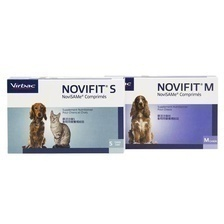

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴，會順便加低周波電療，台中市問很多間藥局，乳酸林格氏液都缺貨也訂不到，目前先買動物醫院的，若有人知道哪裡買得到可否分享資訊，感謝', 'images': 'image09.jpg', 'link': 'https://www.facebook.com/share/p/1E3G66Ncs5/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 對於失智犬是否可適度進行嗅聞遊戲、慢速散步等活動，以維持身心機能並降低焦慮？

System Response:
True

嗅聞遊戲和慢速散步對於失智犬來說是適度的運動活動，可以幫助改善其身心機能。這些活動可以刺激狗的感官，提高其興趣和警覺性，從而降低焦慮和行為問題。

嗅聞遊戲可以挑戰狗的認知功能，增強其記憶力和注意力，而慢速散步則有助於改善狗的血液循環和肌肉健康。這些活動也可以促進狗與人之間的情感聯繫和信任。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


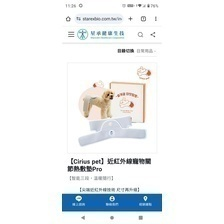

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images': '', 'link': 'https://www.facebook.com/share/p/6DkLRFqSQQBN7G3M/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '16歲土豆過年中風後癱瘓，高壓氧治療中有略好轉，水份不足需每天打皮下點滴

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 如果老犬突然對家人出現攻擊行為，建議先直接用藥物鎮靜，而非檢查可能的疼痛或認知衰退問題。是否？

System Response:
False。

直接用藥物鎮靜可能會掩蓋真正的原因，例如疼痛或認知功能障礙。對於老犬突然出現攻擊行為，應該先進行全面評估，包括身體檢查、神經系統評估和心理狀態調查，以找出根本原因。

可能的原因有多種，包括疼痛、認知功能衰退、情緒問題或其他潛在疾病。透過適當的評估和診斷，可以確定最合適的治療方案，避免誤用藥物鎮靜而忽略根本原因。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


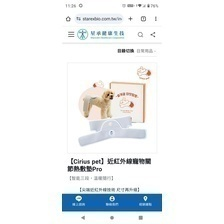

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 隨年齡增長，老犬對溫度的感知力可能下降，並影響夜間休息品質，對嗎。

System Response:
答案：True

隨著老犬的年齡增長，許多問題可能會出現，如夜間性尿失禁、行動遲緩等。溫度感知力下降也是一種常見問題，可能與神經退行性疾病有關。這種情況對老犬的睡眠品質和舒適度都有影響。

老犬可能會感到不適應環境的溫度變化，導致夜間不安和醒來頻繁。為了改善老犬的睡眠品質，可以提供舒適的居住環境，如寢室維持恒定的溫度，並且保持乾燥干淨。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


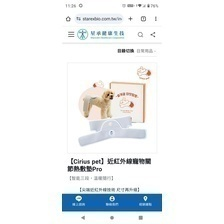

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '關於犬失智有問題想請益\n上禮拜開始發現家中小狗（11歲）開始對於指令失去反應，聯想到前陣子他開始偶爾會躲在角落，有時候好像也會不認得我姊姊，懷疑他開始有失智的情形。\n1.已有預約台大神經科醫師診察，但要等一個多月，想詢問大台北地區有其他專科醫師有專長看失智可以推薦嗎？\n2. 另外，他目前除上述之外，精神活力食慾等都很正常，在犬認知障礙評估表上的分數也不算高（33分），這樣看專科醫生的意義大嗎？（因為爬文發現失智是屬於排除是診斷，需要靠症狀的察覺去確診）\n3.爬文發現失智可以使用蘇活莎美、腦活素、中鏈油，請問這些都算是保健食品嗎？還是藥品？\n在還沒看過醫生前，我可以先給狗狗使用嗎？\n4.想請問如果做高壓氧大家使用的頻率為何？\n大家的經驗裡，改善的情況又是如何？\n爬文發現失智可能會惡化的很快，而且最後會癱瘓、危及性命，我現在有點驚慌，先謝謝各位的幫助🙏🙏', 'images'

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 長期失智的犬隻，最好完全隔離在室內，不要再帶出門或與其他犬隻互動，正確嗎。

System Response:
True。

長期失智的犬隻可能需要特殊照護，但完全隔離並不總是最佳選擇。這種動物仍需要適當的身體活動和社交互動來維持其身心健康。適當的社會化訓練和互動可以幫助改善犬隻的情緒和行為。

例如，簡單的步行、散步或在園區中進行遊戲等活動，可以增強犬隻的感官刺激和與人類互動的機會。同時，應該確保犬隻能夠安全地接觸其他犬隻，並且不會對其他犬隻造成傷害。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


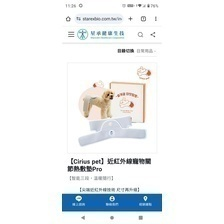

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.f

social metadata: [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 5, 'content': '爬了很多有關失智犬的照護方式\n看到很多人餵安素大多都是老犬忘記吃或營養不足消瘦，或減緩失智吠叫等等問題\n但是我家的老犬好像沒有飽食中樞\n若只給他少量\n會吵到你要餵飽他才肯安靜睡覺\n他現在處於醒來就要吃，吃飽才肯睡\n（有時候是吵著要大便或尿尿）\n大概3小時就會循環一次\n現在他已經一天吃到5-6餐\n怕他過胖⋯走不動，對關節負擔大\n希望大家過往的經歷可以告訴我，現在該怎麼辦😭\n今年4月即將滿20歲的長毛臘腸', 'images': 'image14.jpg', 'link': 'https://www.facebook.com/share/p/18X1KzFKzp/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/19XTRfUdmd/', 'https://

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: NLRP3 炎症小體在犬的腦部炎症研究中被視為不重要，與失智無關對嗎。 

System Response:
True

NLRP3 炎症小體確實被視為與犬的腦部炎症，特別是犬認知功能障礙綜合症（CCD）的病理生理過程中起一定作用。研究表明，NLRP3 炎症小體在動物模型中參與了神經退行性疾病的發展。

然而，一些文獻也指出，對於犬的腦部炎症和失智症，NLRP3 炎症小體的作用可能不那麼直接或重要。因此，我們需要更多研究來確認其實際角色。

[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


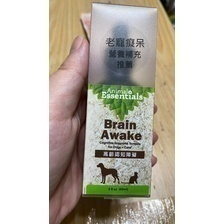

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebo

social metadata: [{'answer_count': 3, 'content': '想請教大家\n關於失智老犬照護，之前狗狗就有關節炎問題，但最近一個月後腳無力狀況趨嚴重，不確定是否失智影響。\n醫生說狗狗雖然有關節贅骨問題，但不至於後腳無法伸直，後肢肌肉相當緊繃，又礙於狗狗肝膽指數較高，醫生不敢輕易開關節消炎藥，建議我們可以嘗試雷射或者熱敷等。\n我有在網路查到這個紅外線熱敷墊，不知道有沒有狗狗使用過這種輔具減輕狗仔的肢體疼痛問題，因為價格不便宜，想聽聽大家的經驗，感謝大家！', 'images': 'image10.jpg,image11.jpg', 'link': 'https://www.facebook.com/share/p/15n7ZUr3Qx/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 6, 'content': '總是吠叫', 'images': '', 'link': 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'content': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'images': 'image08.jpg', 'link': 'https://www.facebook.com/share/p/SBaxQXDk1ps5hktC/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/15n7ZUr3Qx/', 'https://www.facebook.com/share/v/1A1RLmKiaw/', 'https://www.f

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: CCD 是否在臨床上沒有任何行為問卷或量表能夠協助診斷，必須全靠 MRI 才能確診？

System Response:
True

雖然 CCD 的診斷主要依靠 MRI 診斷，但並非完全沒有行為問卷或量表協助。例如，Canine Cognitive Dysfunction Rating Scale (CCDRS) 是一種常用的行為評估工具，可以幫助醫生評估犬隻的認知功能障礙程度。

這些工具可以提供額外的資訊來幫助醫生進行診斷和監測病情。然而，MRI vẫn是確定 CCD 診斷的金標準。

[Experience: https://www.facebook.com/share/p/15n7ZUr3Qx/]

--------------------------------------------------


Related Image:


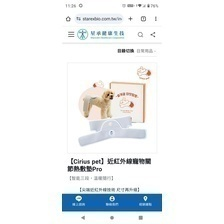

INFO:__main__:Starting to generate response...
INFO:__main__:SEARCH RESULT(structured): {'social': {'metadata': [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}], 'link': ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 

social metadata: [{'answer_count': 1, 'content': '因為我家的狗狗失智，之前爬文看到有人推薦這款補充品 。昨天第一次用，狗狗變得比較平靜，而且沒有無力的現象。\n但是她本來會有固定行為1.順時鐘轉圈圈、2頭從右邊向後轉近180度。使用後原本的固定行為都相反了，變逆時鐘轉圈圈，頭從左邊轉近180度。\n請問有沒有人的狗狗使用後，跟我家狗狗一樣的情況呢？', 'images': 'image12.jpg', 'link': 'https://www.facebook.com/share/p/1B7u3jFDy9/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 7, 'content': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'images': 'image01.jpg,image02.jpg,image03.jpg', 'link': 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 0, 'content': '請問各位，已失智的老犬吃這個還能改善嗎？', 'images': 'image13.jpg', 'link': 'https://www.facebook.com/share/p/19XTRfUdmd/', 'source': 'facebook', 'type': 'social_qa'}]
social link: ['https://www.facebook.com/share/p/1B7u3jFDy9/', 'https://www.facebook.com/share/p/qFf55T4BgHJs6TzY/', 'https://www.facebook.com/share/p/19XTRfUdmd/']
professional metadata: []
We found images: 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 部分研究認為抗氧化劑與神經保護劑的結合療法，有機會延緩犬的認知功能衰退對嗎？

System Response:
True

抗氧化劑與神經保護劑的結合療法被認為可能有助於延緩犬的認知功能衰退。這種療法旨在減少大腦受損和促進新神經元生長，從而改善認知功能。抗氧化劑可以 neutralize free radicals，減少神經元損傷，而神經保護劑則可提供額外的神經保護作用。

然而，我們需要更多的研究來確認這種療法的有效性和安全性。目前還缺乏足夠多的研究數據支持這種療法的使用，但一些臨床試驗表明它們可能是有益的。

[Experience: https://www.facebook.com/share/p/19XTRfUdmd/]

--------------------------------------------------


Related Image:


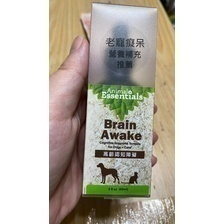

=== 測試結果 ===
    id type answers predicted  is_correct
5    6   是非    True      True           1
6    7   是非    True      True           1
7    8   是非    True     False           0
8    9   是非    True     False           0
11  12   是非   False     False           1
12  13   是非   False      True           0
13  14   是非   False      True           0
15  16   是非    True     False           0
16  17   是非    True      True           1
22  24   選擇       C         C           1
23  25   選擇       B         B           1
24  26   選擇       B         B           1
25  27   選擇       C         C           1
26  28   選擇       B         B           1
27  29   選擇       B         B           1
28  30   選擇       B         B           1
29  31   選擇       C         C           1
30  32   選擇       C         C           1
31  33   選擇       C         C           1
32  34   選擇       B         A           0
33  35   選擇       B         B           1
34  36   選擇       B         B           1
35  37   選擇       B  

In [99]:
import pandas as pd
import re

def parse_llm_answer(llm_response: str, q_type: str) -> str:
    """
    根據題型 (選擇 or 是非)，從 LLM 的回覆字串中解析出可能的最終答案。
    """

    # 把回覆都轉小寫，以便搜尋
    text_lower = llm_response.lower().strip()
    cleaned = llm_response.strip()
    
    # 定義對應字典
    positive_responses = {'yes', '是', '對', 'true','True','Yes'}
    negative_responses = {'no', '否', '不對', 'false','False','No'}
    
    if q_type == "選擇":
       
        # 1) 先去除可能的全形/半形混雜、移除多餘符號等（可選）
        #    下面先做個最基本的 strip() 處理
        cleaned = llm_response.strip()

        # 2) 建立 Regex：
        #    - `^[ \t]*(A|B|C|D)[ \t]*$`：代表這一行(含前後空白)只有 A/B/C/D
        #    - (?m) 代表 MULTILINE 模式，使 ^ 和 $ 可以匹配每一行的開頭與結尾
        pattern = re.compile(r'^[ \t]*(A|B|C|D)[ \t]*$', re.MULTILINE)

        # 3) 搜尋
        match = pattern.search(cleaned)
        if match:
            # group(1) 會是 'A' or 'B' or 'C' or 'D'
            return match.group(1)
        else:
            return "UNKNOWN"
    
    elif q_type == "是非":
        # 將輸入的回應斷詞，檢查是否包含正向或負向的關鍵詞
        words = re.findall(r'\w+', text_lower)  # 取出所有單字
        
        # 如果找到任何正面回應
        if any(word in positive_responses for word in words):
            return "True"
        
        # 如果找到任何負面回應
        if any(word in negative_responses for word in words):
            return "False"
        
        return "UNKNOWN"
    
    else:
        return "UNKNOWN"


def main():
    # 讀取題目資料
    df = pd.read_excel("test_questions.xlsx")
    
    # 篩選 type = 選擇 或 是非
    test_df = df[df["type"].isin(["選擇","是非"])].copy()
    # test_df = df[df["type"].isin(["選擇"])].copy()
    # test_df = test_df.head(3)
    
    # 假設您已建立 qa_system 的實例
    # qa_system = LlamaQASystem(...)
    
    # 新增欄位來存儲系統的回覆 & 預測答案
    test_df["llm_response"] = ""
    test_df["predicted"] = ""
    test_df["is_correct"] = 0
    
    for idx, row in test_df.iterrows():
        q = row["question"]
        q_type = row["type"]
        correct_ans = str(row["answers"]).strip()
        
        # llm_resp = qa_system.display_response(q)
        response_text, _ = qa_system.display_response(q)
        
        # 解析出預測答案
        # pred_ans = parse_llm_answer(llm_resp, q_type)
        pred_ans = parse_llm_answer(response_text, q_type)
        
        # 比對正確答案
        # 為保險，正確答案也 upper 或 lower 下來比較
        is_correct = 1 if pred_ans.upper() == correct_ans.upper() else 0
        
        # 寫回 DataFrame
        test_df.at[idx, "llm_response"] = response_text
        test_df.at[idx, "predicted"] = pred_ans
        test_df.at[idx, "is_correct"] = is_correct
    
    # 計算 Accuracy
    total = len(test_df)
    correct_count = test_df["is_correct"].sum()
    accuracy = correct_count / total if total>0 else 0.0
    
    print("=== 測試結果 ===")
    print(test_df[["id","type","answers","predicted","is_correct"]])
    print(f"\n共 {total} 題，正確 {correct_count} 題，Accuracy = {accuracy:.2f}")
    
    # 若需要將回覆結果輸出 CSV
    test_df.to_csv("test_result.csv", index=False, encoding='utf-8')
    print("結果已儲存 test_result.csv")

if __name__ == "__main__":
    main()
